In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!ls '/content/gdrive/My Drive/Datasets'

celebFace.zip  df_par_attr.csv	images	img_test.zip


In [ ]:
!mkdir data

In [ ]:
 !unzip '/content/gdrive/My Drive/Datasets/celebFace.zip' -d data/

Streaming output truncated to the last 5000 lines.
  inflating: data/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197617.jpg  
  inflating: data/img_align_celeba/img_align_celeba/197618.jpg  
  inflating: data/img_align_celeba/img_

In [ ]:
 import pandas as pd
import numpy as np
import tarfile
import io
import os

# for reading and displaying images
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline

# for creating validation set
from sklearn.model_selection import train_test_split
from skimage import io
import PIL
import torch
# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor, ToPILImage, Normalize, Compose
import torch.nn.functional as F
from IPython.display import display

# PyTorch libraries and modules
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import torch.optim as optim

from timeit import default_timer as timer  

In [ ]:
#import torch
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Running on the GPU")
else:
  device = torch.device("cpu")
  print("Running on the CPU")


Running on the GPU


In [ ]:
torch.cuda.device_count()

1

In [ ]:
main_folder = '/content/data/img_align_celeba'
images_folder ='/content/data/img_align_celeba/img_align_celeba/'
batch_size = 128
epochs = 20

In [ ]:
class CelebTrain(Dataset):
  def __init__(self, csv_file,img_dir, transform=None):
    self.img_dir = img_dir
    self.annotations = pd.read_csv(csv_file,nrows = 5120)
    self.transform = transform

  def __len__(self):
      return len(self.annotations)
    
  def __getitem__(self, index):
      img_path = os.path.join(self.img_dir, self.annotations.iloc[index,0])
      img = Image.open(img_path)
      y_label = torch.tensor(int (self.annotations.iloc[index,1]))

      if self.transform:
        img = self.transform(img)

        return (img, y_label)
      

In [ ]:
class CelebValid(Dataset):
  def __init__(self, csv_file,img_dir, transform=None):
    self.img_dir = img_dir
    self.annotations = pd.read_csv(csv_file, nrows = 2560)
    self.transform = transform

  def __len__(self):
      #print(len(self.annotations))
      return len(self.annotations)
    
  def __getitem__(self, index):
      img_path = os.path.join(self.img_dir, self.annotations.iloc[index,0])
      #img_name = self.img_path[index]
      img = Image.open(img_path)
      y_label = torch.tensor(int (self.annotations.iloc[index,1]))

      if self.transform:
        img = self.transform(img)

        return (img, y_label)
      

In [ ]:
# Creating tensors for the images and their labels
train_data = CelebTrain(csv_file = '/content/data/img_align_celeba/img_align_celeba/train_attr.csv', img_dir = images_folder,
                       transform = transforms.Compose([transforms.Resize(178),transforms.CenterCrop(178)
                                                       ,transforms.ToTensor()]))

valid_data = CelebValid(csv_file = '/content/data/img_align_celeba/img_align_celeba/valid_attr.csv', img_dir = images_folder,
                       transform = transforms.Compose([transforms.Resize(178),transforms.CenterCrop(178),
                                                        transforms.ToTensor()]))

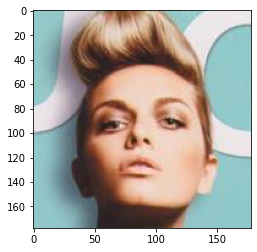

In [ ]:
# To check if images are stored correctly
from matplotlib.pyplot import imshow
import matplotlib.image as mpimg
for i in range(len(train_data)):
    img,label = train_data[i]
    img = img.permute(1,2,0)
    imshow(img)
    if i == 4:
        break

In [ ]:
# loading the data
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle = True)

valid_loader = DataLoader(dataset = valid_data, batch_size = batch_size, shuffle = True)

In [ ]:
# Creating the model
class GenderModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3,32,3, stride = 1)
    self.batch1 = nn.BatchNorm2d(32)
    self.pool1 = nn.MaxPool2d(2,2)
    self.conv2 = nn.Conv2d(32,64,5,stride=1)
    self.batch2 = nn.BatchNorm2d(64)
    self.pool2 = nn.MaxPool2d(2,2)
    self.conv3 = nn.Conv2d(64,128,3,stride=1)
    self.batch3 = nn.BatchNorm2d(128)
    self.pool3 = nn.MaxPool2d(2,2)
    self.conv4 = nn.Conv2d(128, 128, 5, stride=1)
    self.batch4 = nn.BatchNorm2d(128)
    self.pool4 = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(128 * 8 * 8 ,1024)  
    self.drop1 = nn.Dropout(p=0.1)
    self.fc2 = nn.Linear(1024,128)
    self.drop2 = nn.Dropout(p=0.1)
    self.fc3 = nn.Linear(128,2)

  def forward(self,x):
    x   =   self.pool1(F.relu(self.batch1((self.conv1(x)))))
    x   =   self.pool2(F.relu(self.batch2((self.conv2(x)))))
    x   =   self.pool3(F.relu(self.batch3((self.conv3(x)))))
    x   =   self.pool4(F.relu(self.batch4((self.conv4(x)))))
    x   =   x.view(-1, 128 * 8 * 8)
    x   =   self.drop1(x) 
    x   =   F.relu(self.fc1(x))
    x   =   self.drop2(x) 
    x   =   F.relu(self.fc2(x))
    x   =   self.fc3(x)
    return x
print(GenderModel())


GenderModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features

In [ ]:
model1 = GenderModel()
model = model1.to(device)

In [ ]:
def train(): 
    optimizer = torch.optim.SGD(model.parameters(),lr = 0.001, momentum=0.9)   
    criterion = nn.CrossEntropyLoss()
    n_samples = 10240
    total_loss = 0
    total_train = 0
    correct_train = 0.0
    for i,(img, labels) in enumerate(train_loader):
        img = img.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss = total_loss + loss.item()
        #accuracy
        _, predicted = torch.max(output.data, 1)
        predicted = predicted
        total_train += labels.size(0)
        correct_train += predicted.eq(labels.data).sum().item()
        train_accuracy = 100 * correct_train / total_train

        
    losses.append(loss.item())
    train_acy.append(train_accuracy)
    return (train_accuracy,loss.item())

In [ ]:
#n_samp = 5120
def valid(epochs):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        with torch.no_grad():
            for i,(img, labels) in enumerate(valid_loader):
                img = img.to(device)
                labels = labels.to(device)
                outputs = model(img)
                _, predicted = torch.max(outputs.data, 1)
                predicted = predicted
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                acc = 100*correct/total
    valid_acy.append(acc)
    return acc

In [ ]:
!cd data/img_align_celeba/
!mkdir img_test

mkdir: cannot create directory ‘img_test’: File exists


In [ ]:
 !unzip '/content/gdrive/My Drive/Datasets/img_test.zip' -d img_test

Archive:  /content/gdrive/My Drive/Datasets/img_test.zip
replace img_test/img_test/202453.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
img_test_dir = '/content/img_test'

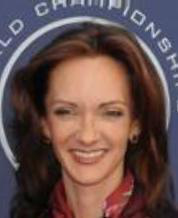

In [ ]:
img = Image.open('/content/img_test/img_test/202457.jpg')
img

In [ ]:

classes = ('Female','Male')
def predict(img_test_dir):
    model.eval()
    #Loading the model
    model1 = torch.load('/content/model.pt',map_location = 'cpu')
    print(model1)
    #Loadind the test image
    img = Image.open(img_test_dir)
    with torch.no_grad():
        trans1 = transforms.Compose([transforms.Resize(178),transforms.CenterCrop(178)
                                                       ,transforms.ToTensor()])
        img_tensor = trans1(img) 
        #Image Transformation
        trans = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        img_tensor = trans(img_tensor)
        print(img_tensor.shape)
        
        single_image_batch = img_tensor.unsqueeze(0) 
        outputs = model1(single_image_batch)
        _, predicted = torch.max(outputs.data, 1)
        class_id = predicted[0].item()
        predicted_class = classes[predicted[0].item()]
        print("Predicted Class : {}".format(predicted_class))
        display(img)
            

Training for 20 epochs
Epoch 0, train Loss: 0.515 Training Accuracy 64.8828125: Valid Accuracy 65.390625
GPU time:  29.345142950999616
Epoch 1, train Loss: 0.464 Training Accuracy 72.59765625: Valid Accuracy 71.71875
GPU time:  28.788375357000405
Epoch 2, train Loss: 0.314 Training Accuracy 81.23046875: Valid Accuracy 85.4296875
GPU time:  28.709919034999984
Epoch 3, train Loss: 0.321 Training Accuracy 88.37890625: Valid Accuracy 87.8515625
GPU time:  28.7421665389993
Epoch 4, train Loss: 0.191 Training Accuracy 91.07421875: Valid Accuracy 92.6171875
GPU time:  28.40375010400021
Epoch 5, train Loss: 0.157 Training Accuracy 93.73046875: Valid Accuracy 92.96875
GPU time:  28.444901443999697
Epoch 6, train Loss: 0.168 Training Accuracy 94.5703125: Valid Accuracy 93.671875
GPU time:  28.4987703099996
Epoch 7, train Loss: 0.084 Training Accuracy 95.703125: Valid Accuracy 94.2578125
GPU time:  28.43446348999987
Epoch 8, train Loss: 0.098 Training Accuracy 95.83984375: Valid Accuracy 94.76562

<function matplotlib.pyplot.legend>

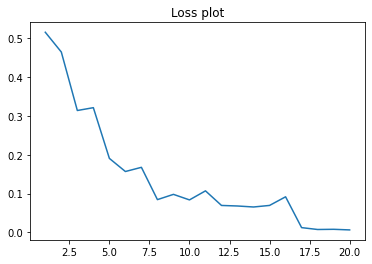

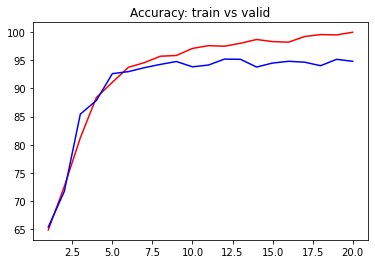

In [ ]:
import sys
import argparse
print("Training for {} epochs".format(epochs))
main_time = timer()
losses = []
train_acy=[]
valid_acy=[]
for epoch in range(epochs):
    start = timer()
    (train_acc,loss_tr)=train()
    valid_acc = valid(epochs)

    print('Epoch {}, train Loss: {:.3f}'.format(epoch ,loss_tr), 'Training Accuracy {}:' .format(train_acc), 'Valid Accuracy {}'.format(valid_acc))
    print("GPU time: ",timer()-start)
print("Model successfully saved at ./model/")
torch.save(model, 'model.pt')
print("Time taken for",epochs,"epochs is",timer()-main_time,"seconds")

epoch = range(1,len(losses)+1)
plt.title("Training Loss plot")
plt.plot(epoch,losses)

plt.figure()
plt.title("Accuracy: train vs valid")
plt.plot(epoch,train_acy,'red',label='Training accuracy')
plt.plot(epoch,valid_acy,'blue',label='Validation accuracy')
plt.legend()
plt.show()


GenderModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1))
  (batch4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features

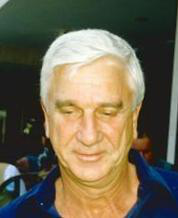

In [ ]:
predict('/content/img_test/img_test/202479.jpg')